In [5]:
from detectron2.data.datasets import register_coco_instances

register_coco_instances("TRAIN_DATASET", {}, "/home/coder/trong/KLTN_SEMI/data/train/_annotations.coco.json", "/home/coder/trong/KLTN_SEMI/data/train")
register_coco_instances("VAL_DATASET", {}, "/home/coder/trong/KLTN_SEMI/data/valid/_annotations.coco.json", "/home/coder/trong/KLTN_SEMI/data/valid")


In [21]:
import os, importlib
from detectron2.config import get_cfg
from ubteacher.config import add_ubteacher_config
from detectron2.data import DatasetCatalog, MetadataCatalog
from detectron2.config import get_cfg
from detectron2.utils.visualizer import Visualizer
import ubteacher.modeling 
from ubteacher.engine.trainer import CustomPredictor
import cv2, random
import matplotlib.pyplot as plt

importlib.import_module("ubteacher.modeling.meta_arch.rcnn")
importlib.import_module("ubteacher.modeling.roi_heads.roi_heads")
importlib.import_module("ubteacher.modeling.proposal_generator.rpn")

cfg = get_cfg()
add_ubteacher_config(cfg) 
cfg.merge_from_file("/home/coder/trong/KLTN_SEMI/code/Unbiased_Teacher/output/config.yaml")
cfg.MODEL.WEIGHTS = os.path.join("/home/coder/trong/KLTN_SEMI/code/Unbiased_Teacher/output/model_best.pth")
cfg.MODEL.ROI_HEADS.NUM_CLASSES = 5
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.5   # Testing threshold
cfg.DATASETS.TRAIN = ("TRAIN_DATASET", )
cfg.DATASETS.TEST = ("VAL_DATASET", )

cfg.freeze()

predictor = CustomPredictor(cfg)

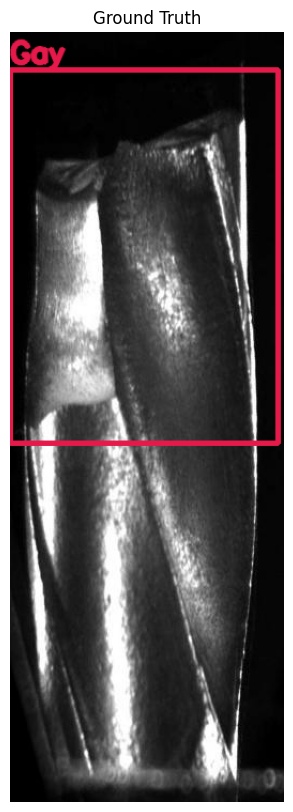

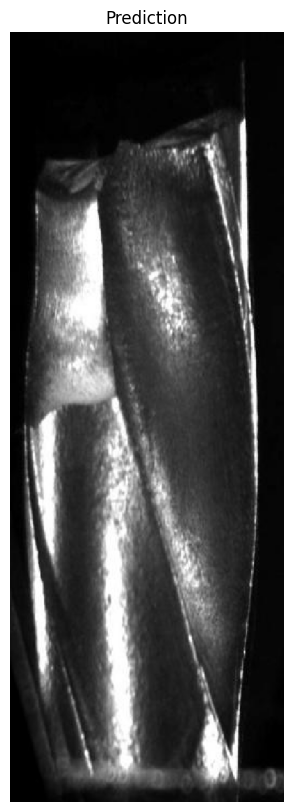

In [23]:
from detectron2.data import MetadataCatalog
dataset_dicts = DatasetCatalog.get("VAL_DATASET")
meta = MetadataCatalog.get("VAL_DATASET")

# Đặt bảng màu cố định (RGB 0-255) cho 6 lớp (đổi nếu bạn có số lớp khác)
# Thứ tự colors sẽ được dùng chung cho cả prediction & ground-truth
meta.thing_colors = [
    (230, 25, 75),   # red
    (60, 180, 75),   # green
    (0, 130, 200),   # blue
    (245, 130, 48),  # orange
    (145, 30, 180),  # purple
]

class_names = getattr(meta, "thing_classes", [])
dataset_id_to_contig = getattr(meta, "thing_dataset_id_to_contiguous_id", None)

for d in random.sample(dataset_dicts, min(1, len(dataset_dicts))):
    im_bgr = cv2.imread(d["file_name"])
    outputs = predictor(im_bgr)

    # ===== Prediction: phóng to font bằng scale =====
    im_rgb = im_bgr[:, :, ::-1]
    v = Visualizer(im_rgb, metadata=meta, scale=1.6)  
    vis_pred = v.draw_instance_predictions(outputs["instances"].to("cpu"))
    pred_rgb = vis_pred.get_image()

    # ===== Ground-truth: tô bbox theo cùng màu class =====
    im_gt_bgr = im_bgr.copy()
    annotations = d.get("annotations", None)
    if annotations:
        for ann in annotations:
            # COCO: bbox = [x, y, w, h] (xywh)
            x, y, w, h = [int(v) for v in ann["bbox"]]
            ds_id = ann.get("category_id")

            # Lấy chỉ số class liên tục để index vào bảng màu & tên lớp
            if dataset_id_to_contig is not None and ds_id in dataset_id_to_contig:
                cid = dataset_id_to_contig[ds_id]
            else:
                cid = ds_id  # fallback (nếu đã contiguous sẵn)

            # Lấy màu RGB theo class rồi đổi sang BGR cho OpenCV
            rgb = meta.thing_colors[cid % len(meta.thing_colors)]
            bgr = (rgb[2], rgb[1], rgb[0])

            name = class_names[cid] if cid < len(class_names) else str(cid)

            # Vẽ bbox & tên lớp
            cv2.rectangle(im_gt_bgr, (x, y), (x + w, y + h), bgr, 3)
            cv2.putText(im_gt_bgr, name, (x, max(0, y - 7)),
                        cv2.FONT_HERSHEY_SIMPLEX, 0.9, bgr, 3, lineType=cv2.LINE_AA)

    # Hiển thị GT với màu khớp class/predict
    plt.figure(figsize=(10, 10))
    plt.imshow(im_gt_bgr[:, :, ::-1])  # BGR -> RGB
    plt.title("Ground Truth"); plt.axis("off")
    plt.show()
    # Hiển thị prediction
    plt.figure(figsize=(10, 10))
    plt.imshow(pred_rgb)  # Visualizer trả RGB
    plt.title("Prediction"); 
    plt.axis("off")
    plt.show()


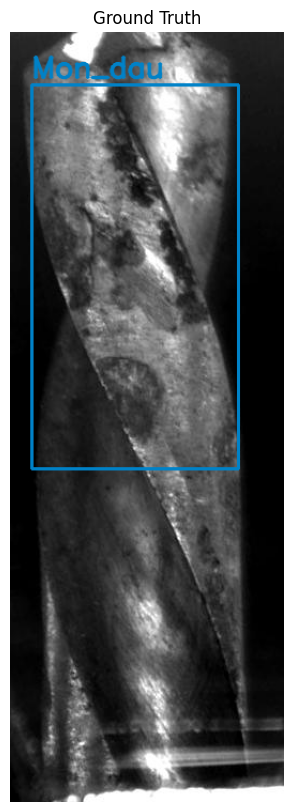

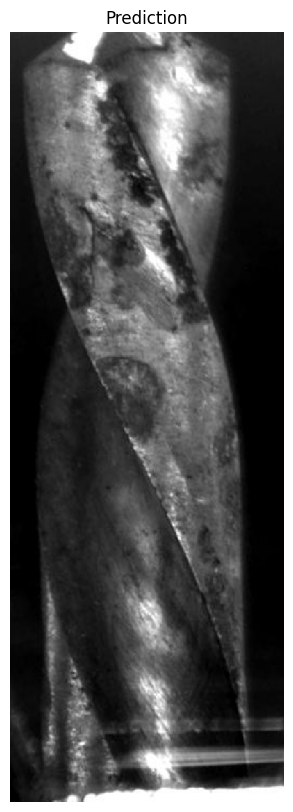

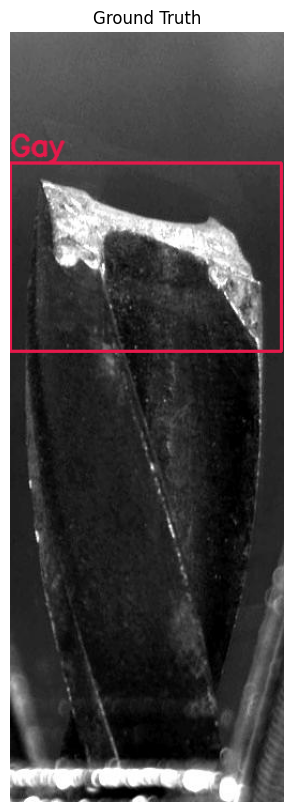

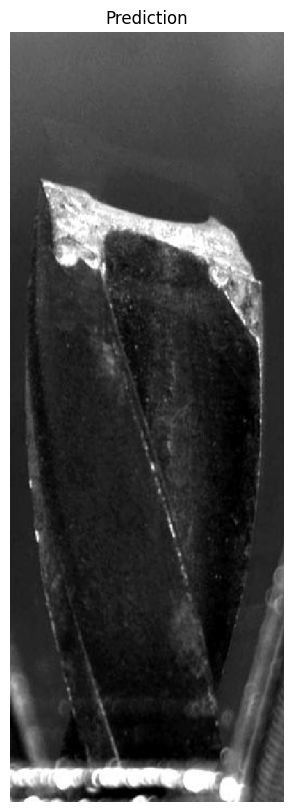

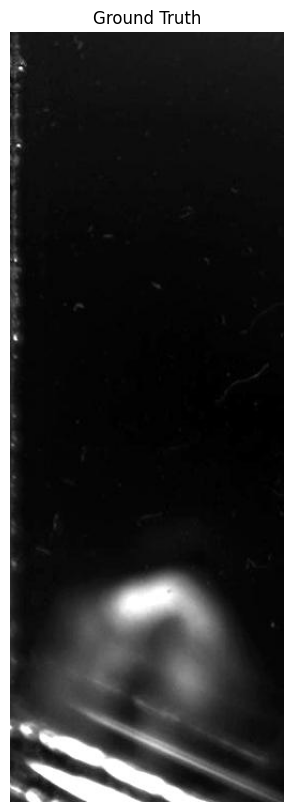

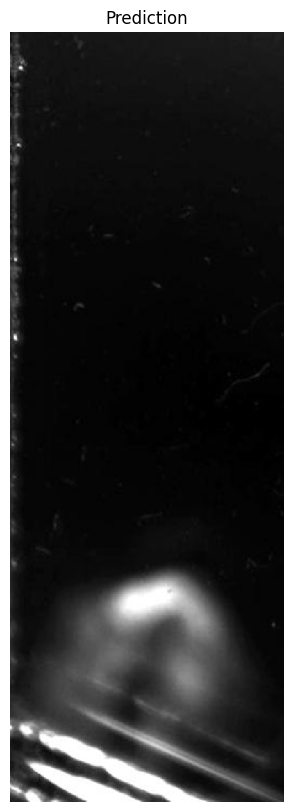

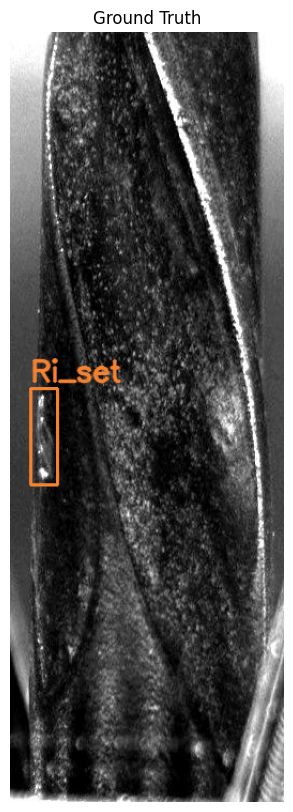

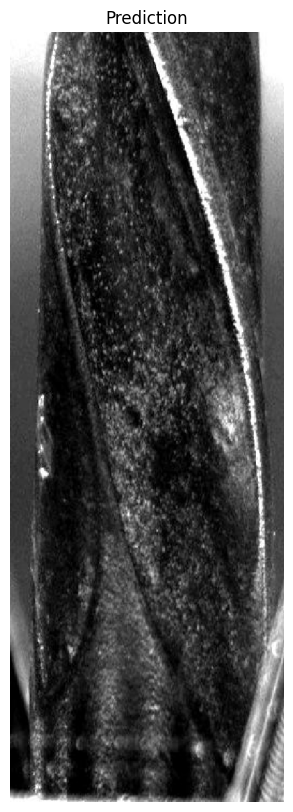

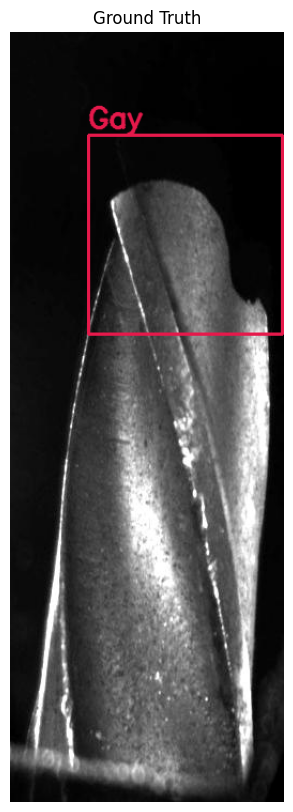

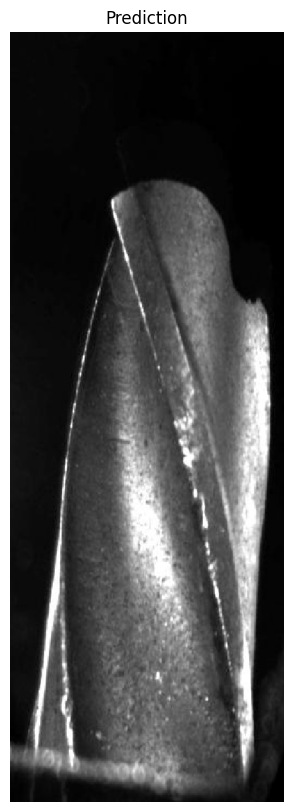

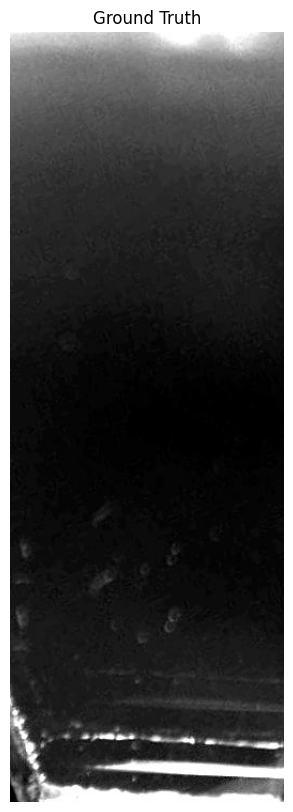

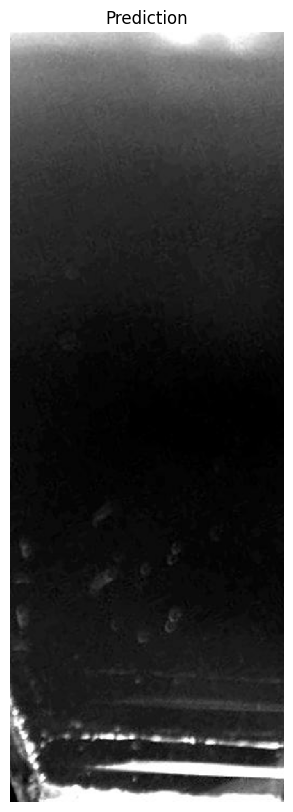

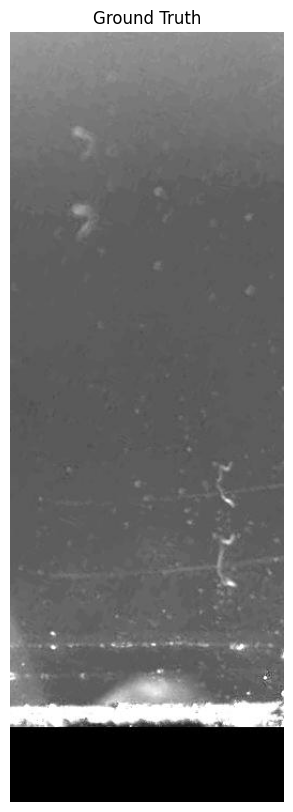

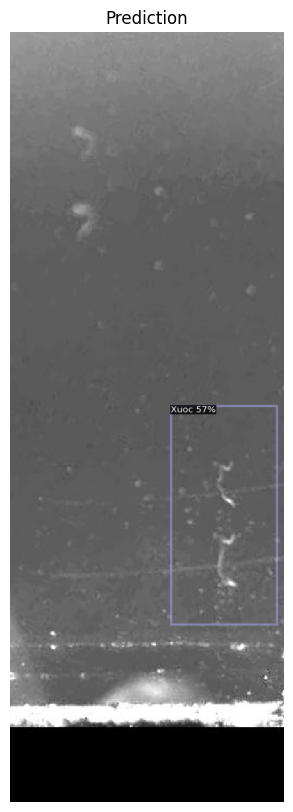

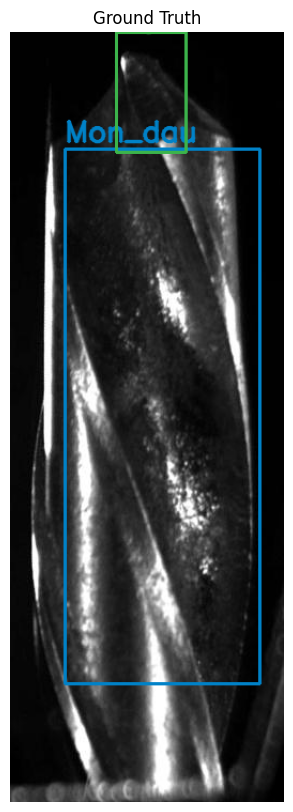

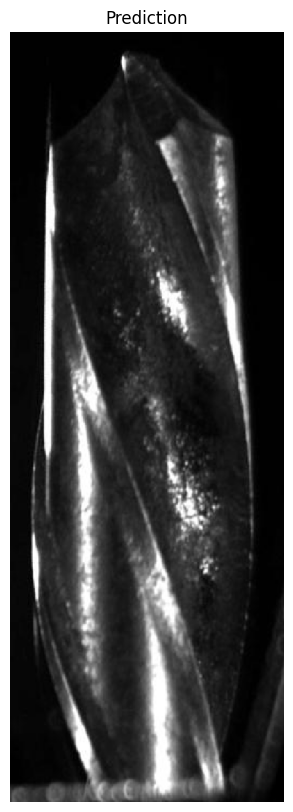

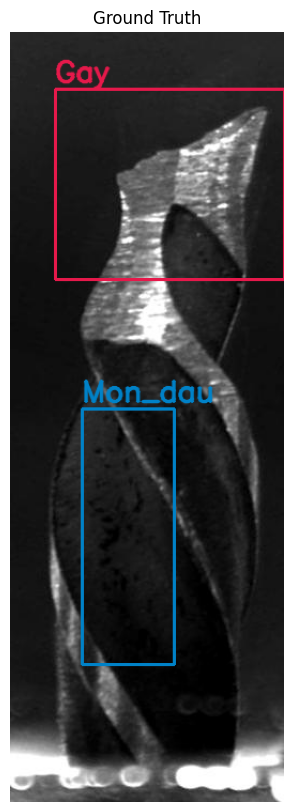

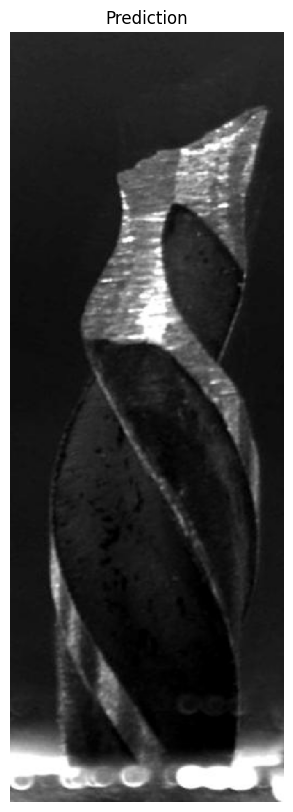

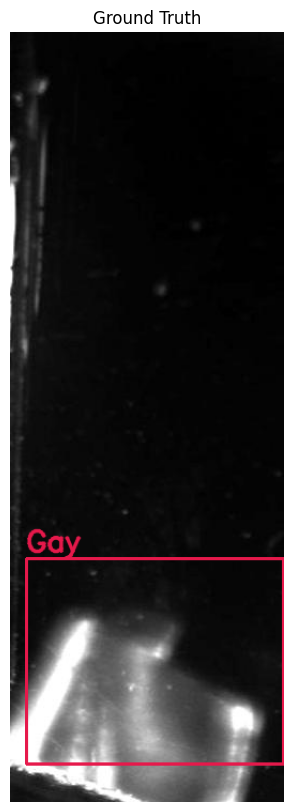

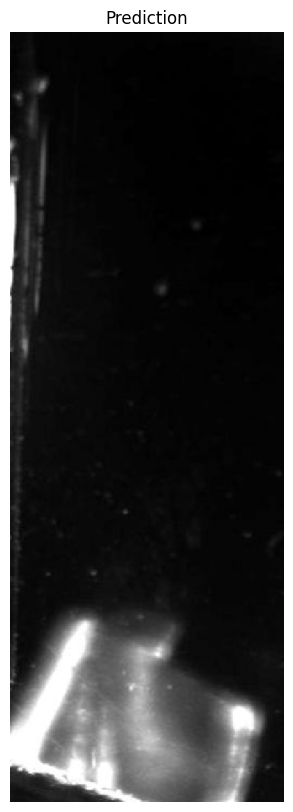

In [25]:
for d in random.sample(dataset_dicts, min(10, len(dataset_dicts))):
    im_bgr = cv2.imread(d["file_name"])
    outputs = predictor(im_bgr)

    # ===== Prediction: phóng to font bằng scale =====
    im_rgb = im_bgr[:, :, ::-1]
    v = Visualizer(im_rgb, metadata=meta, scale=1.6)  
    vis_pred = v.draw_instance_predictions(outputs["instances"].to("cpu"))
    pred_rgb = vis_pred.get_image()

    # ===== Ground-truth: tô bbox theo cùng màu class =====
    im_gt_bgr = im_bgr.copy()
    annotations = d.get("annotations", None)
    if annotations:
        for ann in annotations:
            # COCO: bbox = [x, y, w, h] (xywh)
            x, y, w, h = [int(v) for v in ann["bbox"]]
            ds_id = ann.get("category_id")

            # Lấy chỉ số class liên tục để index vào bảng màu & tên lớp
            if dataset_id_to_contig is not None and ds_id in dataset_id_to_contig:
                cid = dataset_id_to_contig[ds_id]
            else:
                
                cid = ds_id  # fallback (nếu đã contiguous sẵn)

            # Lấy màu RGB theo class rồi đổi sang BGR cho OpenCV
            rgb = meta.thing_colors[cid % len(meta.thing_colors)]
            bgr = (rgb[2], rgb[1], rgb[0])

            name = class_names[cid] if cid < len(class_names) else str(cid)

            # Vẽ bbox & tên lớp
            cv2.rectangle(im_gt_bgr, (x, y), (x + w, y + h), bgr, 2)
            cv2.putText(im_gt_bgr, name, (x, max(0, y - 7)),
                        cv2.FONT_HERSHEY_SIMPLEX, 0.9, bgr, 2, lineType=cv2.LINE_AA)

    # Hiển thị GT với màu khớp class/predict
    plt.figure(figsize=(10, 10))
    plt.imshow(im_gt_bgr[:, :, ::-1])  # BGR -> RGB
    plt.title("Ground Truth"); plt.axis("off")
    plt.show()
    # Hiển thị prediction
    plt.figure(figsize=(10, 10))
    plt.imshow(pred_rgb)  # Visualizer trả RGB
    plt.title("Prediction"); 
    plt.axis("off")
    plt.show()
